In [1]:
from typing import Dict

import matplotlib.pyplot as plt
from torch import Tensor, arange, argwhere, atan2, cat, cos, diff
from torch import empty as empty_tensor
from torch import (float32, gradient, linspace, logical_and, meshgrid, norm,
                   pi, sin, stack, tensor, where, zeros, zeros_like)
from torch.nn import functional as F

from beam_properties import (angular_edges_on_arc, beams_basic_properties,
                             beams_line_properties,
                             sample_ppdf_on_arc_2d_local)
from convex_hull_helper import convex_hull_2d, sort_points_for_hull_batch_2d
from geom_2d_plot import (plot_new_ppdf_mpl, plot_polygons_from_vertices_mpl,
                          plot_scanner_from_vertices_2d_mpl)
from geometry_2d_io import load_scanner_layout_geometries, load_scanner_layouts
from geometry_2d_utils import (fov_tensor_dict, pixels_coordinates,
                               pixels_to_detector_unit_rads)
from ppdf_io import load_ppdfs_data_from_hdf5

In [2]:
scanner_layouts_dir = "../../../pymatcal/scanner_layouts"
scanner_layouts_filename = "scanner_layouts_77faff53af5863ca146878c7c496c75e.tensor"

ppdfs_dataset_dir = (
    "../../../../data/scanner_layouts_77faff53af5863ca146878c7c496c75e"
)

# Load the scanner layouts
scanner_layouts_data, filename_unique_id = load_scanner_layouts(
    scanner_layouts_dir, scanner_layouts_filename
)

# Define the Field of View (FOV) tensor dictionary


fov_dict = fov_tensor_dict(
    n_pixels=(512, 512),
    mm_per_pixel=(0.25, 0.25),
    center_coordinates=(0.0, 0.0),
)
fov_points_2d = pixels_coordinates(fov_dict)

In [3]:
# Define the layout index to load
layout_idx = 0

# Load the scanner geometry
plates_vertices, detector_units_vertices = load_scanner_layout_geometries(
    layout_idx, scanner_layouts_data
)

# Set the PPDFs filename for a particular scanner position
ppdfs_hdf5_filename = f"position_{layout_idx:03d}_ppdfs.hdf5"

# Load the PPDFs data
ppdfs = load_ppdfs_data_from_hdf5(
    ppdfs_dataset_dir, ppdfs_hdf5_filename, fov_dict
)

# Print the shapes of the loaded data
print(
    f"Layout {layout_idx}:\n"
    + f"Metal plates shape  : {list(plates_vertices.shape)}\n"
    + f"Detector units shape: {list(detector_units_vertices.shape)}\n"
    + f"PPDFs data shape:     {list(ppdfs.shape)}"
)

detector_unit_centers = detector_units_vertices.mean(dim=1)
fov_corners = (
    tensor([[-1, -1], [1, -1], [1, 1], [-1, 1]]) * fov_dict["size in mm"] * 0.5
)

hull_points_batch = cat(
    (
        fov_corners.unsqueeze(0).expand(
            detector_units_vertices.shape[0], -1, -1
        ),
        detector_unit_centers.unsqueeze(1),
    ),
    dim=1,
)
hull_points_batch = sort_points_for_hull_batch_2d(hull_points_batch)
print(f"Shape of hull points batch: {list(hull_points_batch.shape)}")

Layout 0:
Metal plates shape  : [88, 4, 2]
Detector units shape: [726, 4, 2]
PPDFs data shape:     [726, 262144]
Shape of hull points batch: [726, 5, 2]


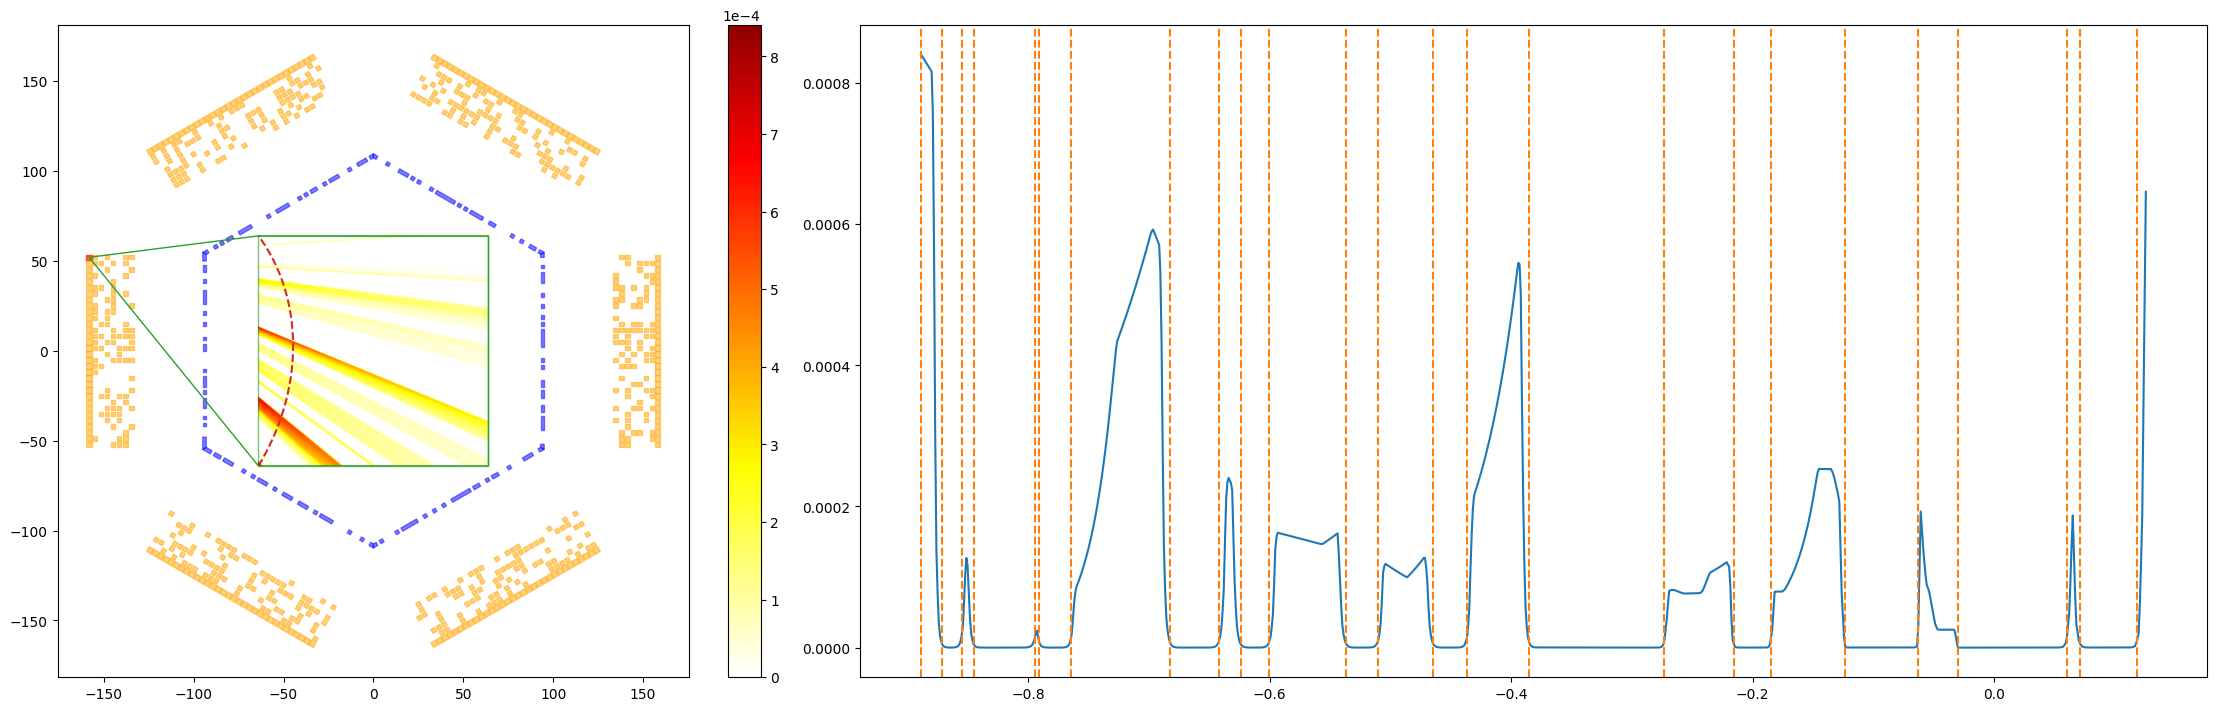

In [21]:
# define the detector unit index
detector_unit_idx = 452
ppdf_data_2d = ppdfs[detector_unit_idx].view(
    int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
)
# Calculate the convex hull for the detector unit
hull_2d = convex_hull_2d(hull_points_batch[detector_unit_idx])

# Sample the PPDFs on the arc of the convex hull
(sampled_ppdf, sampling_rads, sampling_points) = sample_ppdf_on_arc_2d_local(
    ppdf_data_2d, detector_unit_centers[detector_unit_idx], hull_2d, fov_dict
)

relative_sampled_ppdf = sampled_ppdf / sampled_ppdf.max()
radian_edges = angular_edges_on_arc(
    sampled_ppdf,
    sampling_rads,
)

# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(22, 7),
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 2)},
)

ax = axs[0]
scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, ax, fov_dict
)
selected_detector_unit_polycoll = plot_polygons_from_vertices_mpl(
    detector_units_vertices[detector_unit_idx].unsqueeze(0),
    ax,
    color="red",
    alpha=0.5,
)

convex_hull_polycoll = plot_polygons_from_vertices_mpl(
    hull_2d.unsqueeze(0), ax, fc="none", ec="C2"
)
ppdf_im_obj = plot_new_ppdf_mpl(
    ppdf_data_2d,
    ax,
    fov_dict,
)
ax.plot(sampling_points[:, 0], sampling_points[:, 1], "--", color="C3")
ax.autoscale()
ax.set_aspect("equal")

ax = axs[1]
ax.plot(
    sampling_rads,
    sampled_ppdf,
    color="C0",
)
for radian in radian_edges:
    ax.axvline(radian, color="C1", linestyle="--")

In [17]:

relative_sampled_ppdf = sampled_ppdf / sampled_ppdf.max()
radian_edges = angular_edges_on_arc(
    sampled_ppdf,
    sampling_rads,
)
fov_points_rads = pixels_to_detector_unit_rads(
    fov_points_2d,
    detector_unit_centers[detector_unit_idx],
)
beams_basic_properties_dict = beams_basic_properties(
    ppdfs[detector_unit_idx],
    fov_points_2d,
    fov_points_rads,
    radian_edges,
    detector_unit_centers[detector_unit_idx],
)
print(
    "Number of beams:",beams_basic_properties_dict["number of beams"].item(),
)
for beam_id, number in enumerate(beams_basic_properties_dict["number of pixels"]):
    print("Beam ID:", beam_id, "Number of pixels:", number.item())

Number of beams: 2
Beam ID: 0 Number of pixels: 26249
Beam ID: 1 Number of pixels: 2880


KeyError: 'sampled data'

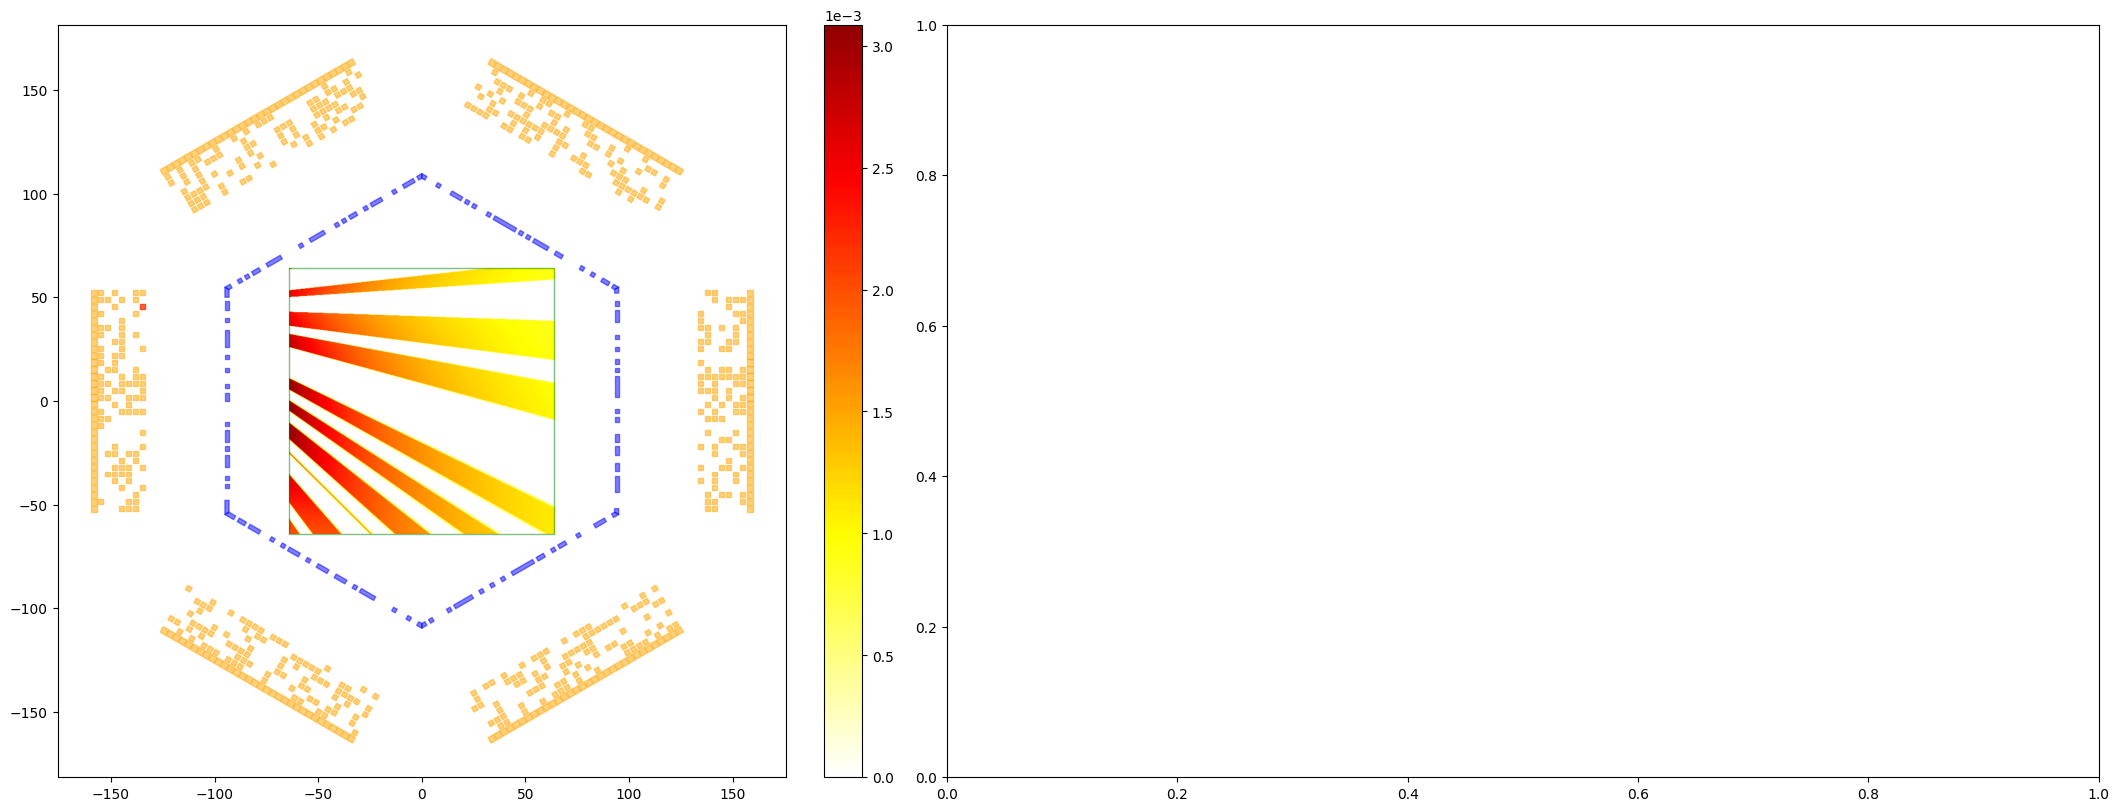

In [12]:
plt.close("all")
# Plot the PPDFs and the scanner layout
fig, axs = plt.subplots(
    1,
    2,
    figsize=(21, 8),
    layout="constrained",
    gridspec_kw={"width_ratios": (1, 1.5)},
)

scanner_polycoll = plot_scanner_from_vertices_2d_mpl(
    plates_vertices, detector_units_vertices, axs[0], fov_dict
)
selected_detector_unit_polycoll = plot_polygons_from_vertices_mpl(
    detector_units_vertices[detector_unit_idx].unsqueeze(0),
    axs[0],
    color="red",
    alpha=0.5,
)

hull_mpl_obj = plot_polygons_from_vertices_mpl(hull_2d.unsqueeze(0), axs[0], visible=False)


ppdf_data_2d = ppdfs[detector_unit_idx].view(
    int(fov_dict["n pixels"][0]), int(fov_dict["n pixels"][1])
)
ppdf_im_obj = plot_new_ppdf_mpl(
    ppdf_data_2d,
    axs[0],
    fov_dict,
)
axs[0].autoscale()
axs[0].set_aspect("equal")
# Plot the sampled beams

beam_sp_distance = arange(4096) * (64.0 / 4096.0) - 32.0
n_beams = beams_properties["number of beams"]
sampled_beams_batch = beams_properties["sampled data"]
x_bounds_batch = beams_properties["fwhm distance bounds"]
beams_centers = beams_properties["weighted centers"]
ax = axs[1]
for i in range(n_beams):
    ax.plot(
        beam_sp_distance.tolist(),
        sampled_beams_batch[i].tolist(),
        label=f"Beam {i:02}, width: {beams_properties["fwhm"][i].item():.2f} mm, sensitivity: {beams_properties["sensitivities"][i].item():.2e}, relative sensitivity: {beams_properties["relative sensitivities"][i].item():.2f}",
    )
    beam_axial_line = axs[0].axline(
        xy1=(
            detector_unit_centers[detector_unit_idx, 0].item(),
            detector_unit_centers[detector_unit_idx, 1].item(),
        ),
        xy2=(beams_centers[i, 0].item(), beams_centers[i, 1].item()),
        color="k",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
    )
    beam_axial_line.set_clip_path(
        hull_mpl_obj.get_paths()[0], transform=beam_axial_line.axes.transData
    )
for i in range(n_beams):
    ax.plot(
        [x_bounds_batch[i, 0].item(), x_bounds_batch[i, 1].item()],
        [
            sampled_beams_batch[i].max().item() * 0.5,
            sampled_beams_batch[i].max().item() * 0.5,
        ],
        ":k",
    )
ax.set_xlim(-20, 20)
ax.set_xlabel("distance (mm)")
ax.set_title("Beams cross-section profile")
ax.legend()